# Regularization & Validation

## Data Generation with correlated features

For an input $x_i$, we generate a label $y_i$ by using a fixed $\mathbf{w}$ and a random normal variable $ϵ ∼ N(0, 0.1^2)$ in the following fashion:

$$ y_i = \mathbf{w}^{T}x_i + ϵ$$

We generate a dataset with 100 samples, each having 50 features. We sample the first 25 features from a gaussian - meaning they are uncorrelated, and add 25 more features that are linearly correlated with the current ones.

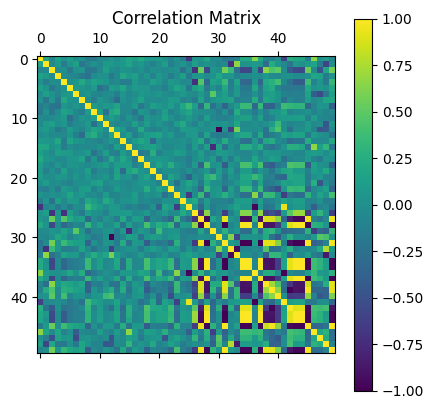

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

n = 100
d = 25

# Dataset with 25 uncorrelated features
np.random.seed(7)
# X = np.random.normal(size=(n, d))

X, y = make_regression(n_samples=n, n_features=d, noise=1, random_state=2)

# Add 25 correlated features:
for j in range(d):
  a = np.random.normal(size=d+j)
  new_feature = X@np.vectorize(lambda i: int(i)*np.random.randint(-2, high=2))(a>1)
  X = np.c_[X, new_feature]

X = X.T

plt.matshow(np.corrcoef(X))
cb = plt.colorbar()
cb.ax.tick_params()
plt.title('Correlation Matrix');

We then make a sparse $\mathbf{w}$ vector with 10/50 features non-zero. We use this to generate $\mathbf{y}$ using the model discussed above.

In [ ]:
d *= 2
np.random.seed(69)
r_d = 10

# Make sparse w with 10 features
w = np.zeros(d)
relevant = np.random.randint(0, high=d-1, size=r_d)

# Assign some weight to these features only
w[relevant] = np.random.normal(scale=2, size=r_d)

# Create some noise, and find predictors
y = w.T @ X + np.random.normal(scale=0.01, size=n)

# Maximum-Likelihood Estimator for finding **w**

The closed form solution for the ML estimator to solve the linear regression problem with the given probabilistic model is the following:

$$\hat{\mathbf{w}}_{ML} = (XX^T)^†Xy$$

In [ ]:
w_hat_ml = np.linalg.pinv(X @ X.T) @ X @ y

# Goodness of ML Estimator

To quantify "goodness" of our estimator, we look at the **Mean Squared Error**.

**Mean Squared Error**: Let $\mathbf{\hat{w}}$ be an estimator of an unknown parameter $\mathbf{w}$. Then we define

$$\text{MSE}(\mathbf{\hat{w}}) = \mathbb{E}[||\mathbf{\hat{w}} - \mathbf{w}||^2]$$

as the Mean Squared Error of our estimator.

## Bias-Variance Decomposition of MSE

The above formula for mean squared error can be rewritten as

$$\text{MSE}(\mathbf{\hat{w}}) = \text{tr}(\text{Var}(\mathbf{\hat{w}})) + ||\text{Bias}(\mathbf{\hat{w}})||^2$$

where $\text{tr}(\text{Var}(\mathbf{\hat{w}}))$ is the trace of the covariance matrix, and
$$\text{Bias}(\mathbf{\hat{w}}) = \mathbb{E}[\mathbf{\hat{w}}] - \mathbf{w}$$

is the bias, i.e, the expected difference between the estimator $\mathbf{\hat{w}}$ and true value $\mathbf{w}$.

### Applying Bias-Variance decomposition on ML Estimator of **w**

The ML Estimator has zero bias; so we get

$$\begin{alignat}{2}
&& \text{MSE}(\mathbf{\hat{w}}_{ML})
& = \text{tr}(\text{Var}(\mathbf{\hat{w}}_{ML})) \\
&&
& = \sigma^2 ̇* \text{tr}((XX^T)^{-1})
\end{alignat}$$

### Derivation of decomposition

We use the below well-known formula relating the covariance matrix $\text{Var}(X)$ to the first and second moments:
$$\mathbb{E}[X^2] = (\mathbb{E}[X])^2 + \text{Var}(X)$$

Therefore we have,

$$
\begin{alignat}{2}
&& \text{MSE}(\mathbf{\hat{w}})
& = \mathbb{E}[||\mathbf{\hat{w}} - \mathbf{w}||^2] \\
&& & = (\mathbb{E}[||\mathbf{\hat{w}} - \mathbf{w}||])^2 + \text{Var}(||\mathbf{\hat{w}} - \mathbf{w}||)\\
&& & = ||\mathbb{E}[\mathbf{\hat{w}}] - \mathbf{w}||^2 + \text{Var}(||\mathbf{\hat{w}}||) \\
&& & = ||\text{Bias}(\mathbf{\hat{w}})||^2 + \text{tr}(\text{Var}(\mathbf{\hat{w}}))
\end{alignat}
$$

Source: [Wikipedia](https://en.wikipedia.org/wiki/Mean_squared_error#Proof_of_variance_and_bias_relationship)

## In pursuit of a *better* estimator

We see that the goodness of the ML estimate depends on the variance of error $σ^2$ and $\text{tr}((XX^T)^{-1})$. We would like to reduce this quantity.

The variance of error is inherent to the experimental setup, and reduction of this quantity therefore depends on qualitative improvements of instruments/peripherals used to collect data. So we cannot hope to reduce this quantity from a mathematical perspective.

The trace depends on $(XX^T)^{-1}$, which denotes the inverse covariance matrix of the data $X$. The covariance matrix captures how the features are related with each other, and it seems that this relation affects the goodness of our estimator. We may try to tweak this value to reduce the trace value, thereby increasing the goodness of our ML estimator.

### Reducing the Trace value

The trace of a matrix $X$ can also be represented as the sum of the eigenvalues of $X$.

Let $\mathbf{λ}$ denote the set of eigenvalues of $XX^T$. Then $$\{ \frac{1}{λ_i} \; ∀ \; i \; \epsilon \; \{1, 2, .., n\} \}$$ is the set of eigenvalues of $(XX^T)^{-1}$ and its trace thus is the following:

$$\text{tr}((XX^T)^{-1}) = \sum_{i=1}^{d}\frac{1}{λ_i}$$

Now, we'd like to reduce this value. A way forward would be to increase the eigenvalues of $XX^T$ by doing the following:

$$\text{eigenvalues of } (XX^T + λI) = \{ λ_i + λ \; ∀ \; i \; \epsilon \; \{1, 2, .., n\} \}$$

which will result in a smaller trace value (due to increase in denominator): $$\text{tr}((XX^T + λI)^{-1}) = \sum_{i=1}^{d}\frac{1}{λ_i + λ}$$

However, this process reformulates the problem the estimator is trying to solve (trade-off) to the following:

$$\hat{\mathbf{w}}_{\lambda - ML} = (XX^T + λI)^{-1}Xy$$

This induces a non-zero bias in our estimator:

$$
\begin{alignat}{2}
&& \text{Bias}(\mathbf{\hat{w}}_{\lambda-ML})
& = \mathbb{E}[\mathbf{\hat{w}}_{\lambda-ML}] - \mathbf{w}\\
&& & = [(XX^T + λI)^{-1} - (XX^T)^†](XX^T)\mathbf{w}
\end{alignat}
$$

The difference between the MSE of our estimators is then:

$$
\begin{alignat}{3}
&&& \text{MSE}(\mathbf{\hat{w}}) - \text{MSE}(\mathbf{\hat{w}}_{\lambda-ML})
&& = \text{tr}(\text{Var}(\mathbf{\hat{w}})) - \text{tr}(\text{Var}(\mathbf{\hat{w}}_{\lambda-ML}))
& \quad - \quad\text{(A)} \\
&&& && \quad - || \text{Bias}(\mathbf{\hat{w}}_{\lambda-ML}) ||^2
& \quad - \quad\text{(B)} \\
\end{alignat}
$$

Note that both $\text{(A)}$ and $\text{(B)}$ are *positive* quantities, hence the difference can either be *positive* or *negative*; The difference depends on the parameter $\lambda$.

The existence theorem asserts that there exists some **non-zero** $λ$ such that the MSE of $\hat{\mathbf{w}}_{\lambda - ML}$ is lower than that of $\hat{\mathbf{w}}_{ML}$, i.e we get $\text{(A)} > \text{(B)}$.

# Ridge Regression
The method of estimating $w$ while reducing the effect inter-correlated variables have on the ML estimator for linear regression is called Ridge Regression.

The objective of the ridge regression problem is given as follows:

$$\underset{w}{\arg \min} \sum_{i=1}^{n}(w^Tx_i-y_i)^2 + λ||w||^2_2$$

The $λ$ term is called the regularizer, and is a hyperparameter, which can be chosen through the cross-validation technique, described at the end of this notebook.

## Closed-Form Solution for Ridge Estimator

It is the same as the aforementioned $\hat{\mathbf{w}}_{\lambda - ML}$:

$$\hat{\mathbf{w}}_{\lambda - ML} = (XX^T + λI)^{-1}Xy$$

It's good to know that the inverse of $(XX^T + λI)$ always exists since:
1. $(XX^T)$ is positive semi-definite
2. $\lambda > 0$

Hence $(XX^T + λI)$ is a positive definite matrix (i.e. all eigenvalues are strictly positive - full rank) - indicating its inverse **exists**.

In [ ]:
l = 10
w_hat_ridge = np.linalg.inv(X @ X.T + l * np.eye(d)) @ X @ y

# Comparison of Ridge and Linear Regression Solutions

The $\lambda ||w||^2_2$ term in the objective function for Ridge regression penalizes the score for $w$'s with greater length. This thus pushes the ridge estimator closer to the origin, resulting in smaller values in its components.

We show the effect of varying $\lambda$ over the coefficients of ridge

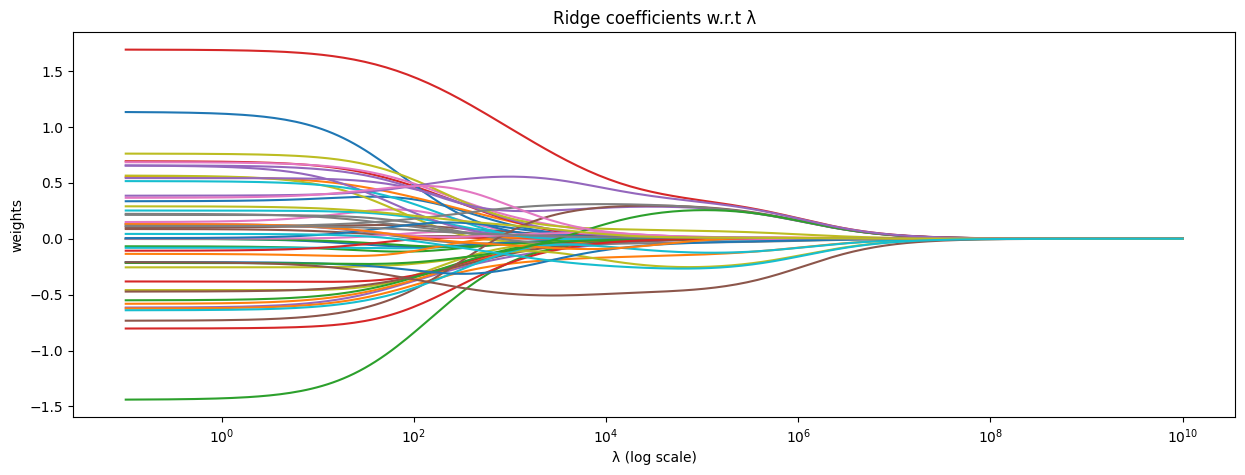

In [ ]:
#|column: screen-inset-left

lambdas = np.logspace(-1, 10 , 200)

from sklearn.linear_model import Ridge

coefs = []
for l in lambdas:
  w_hat_ridge = np.linalg.pinv(X @ X.T + l * np.eye(d)) @ X @ y
  coefs.append(w_hat_ridge)

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(lambdas, coefs)
ax.set_xscale("log")
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("λ (log scale)")
plt.ylabel("weights")
plt.title("Ridge coefficients w.r.t λ")
plt.axis("tight")
plt.show()

# Lasso Regression

The objective for the lasso regression problem is as follows:

$$\underset{w}{\arg \min} \sum_{i=1}^{n}(w^Tx_i-y_i)^2 + λ||w||^2_1$$

The only difference between Lasso and Ridge is that Lasso uses the L1 norm (manhattan distance), in contrast to the L2 norm (euclidean distance) used by Ridge regression. This difference adds sparsity to the Lasso estimator; i.e, some feature co-efficients are pushed to 0; these features do not play a role in the final prediction.

In this context, Lasso can be said to perform feature-selection. Lasso also acts as a regularizer, in terms of constraining the length of the estimator.

## Solution for Lasso Regression

There exists no closed form solution for Lasso, due to the constraint boundaries having points which are not differentiable.

Hence we may use the method of gradient descent, with the help of subgradients to find the Lasso estimator.

In this notebook we use scikit-learn's implementation of Lasso to demonstrate the effect of the Lasso objective on our estimator.

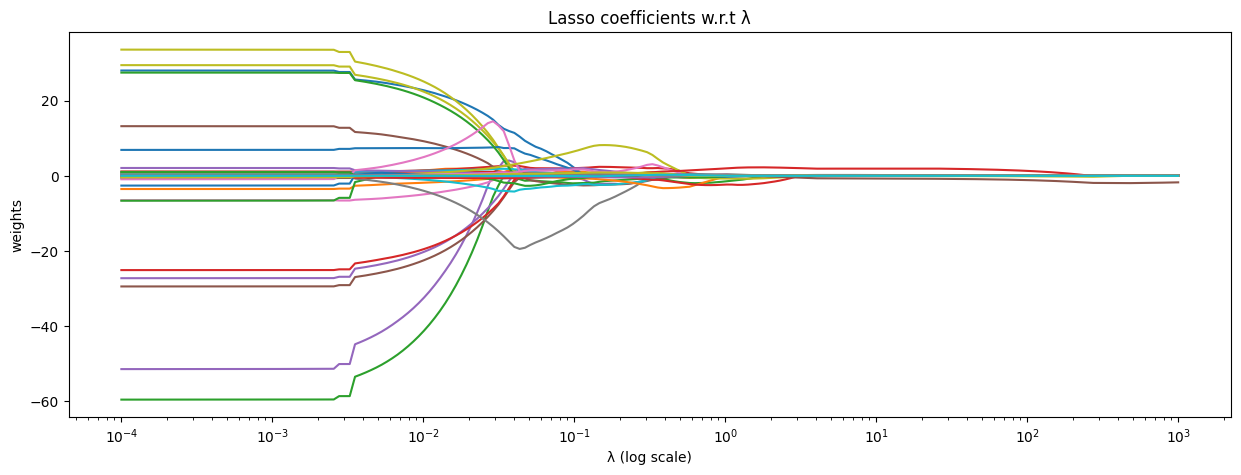

In [ ]:
#|column: screen-inset-left

import warnings
warnings.filterwarnings("ignore")

lambdas = np.logspace(-4, 3 , 200)

from sklearn.linear_model import Lasso

coefs = []
for l in lambdas:
  lasso = Lasso(alpha=l, max_iter=int(1e3)).fit(X.T, y)
  coefs.append(lasso.coef_)

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(lambdas, coefs)
ax.set_xscale("log")
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel("λ (log scale)")
plt.ylabel("weights")
plt.title("Lasso coefficients w.r.t λ")
plt.axis("tight")
plt.show()

# Best λ?

We discuss strategies that can be used to find λ which reduces the MSE for our linear regression problem.

## Validation
- We partition our dataset (features and labels) into 2 - the train and validation sets respectively.
- We construct a set of candidate values for λ and find their corresponding estimators $\hat{\mathbf{w}}_{\lambda - ML}$ using the train dataset.
- We then use these estimators on the validation dataset and find the MSE.
- We choose the $λ$ that gives the least MSE.

Best Lambda: 0.0986265846131283


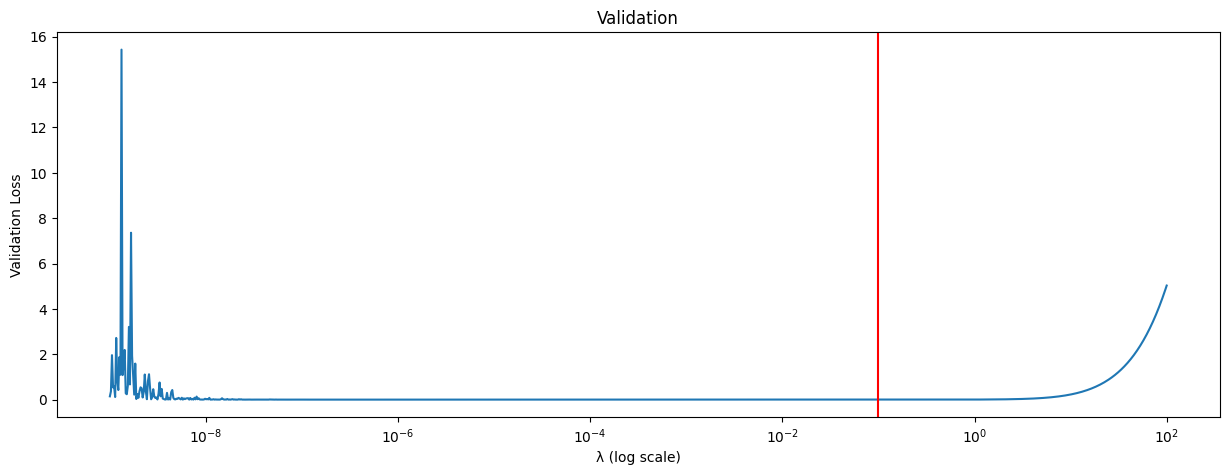

In [ ]:
#|column: screen-inset-left

candidate_lambdas = list(np.logspace(-9, 2, 1000))

X_train, X_val, y_train, y_val = X[:, :int(0.66*n)], X[:, int(0.66*n):], y[:int(0.66*n)], y[int(0.66*n):]

def validate(X_train, X_val, y_train, y_val, l):

  w_hat_l_ml = np.linalg.pinv(X_train @ X_train.T + l * np.eye(d)) @ X_train @ y_train
  l_mse = np.linalg.norm(X_val.T @ w_hat_l_ml - y_val)**2 / len(y_val)

  return l_mse

lst = [validate(X_train, X_val, y_train, y_val, l) for l in candidate_lambdas]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(candidate_lambdas, lst)
ax.set_xscale("log")

best_lambda, best_loss = min(zip(candidate_lambdas, lst), key=lambda i: i[-1])
plt.axvline(x=best_lambda, color='red')

plt.xlabel("λ (log scale)")
plt.ylabel("Validation Loss")
plt.title("Validation")
plt.axis("tight");

print(f'Best Lambda: {best_lambda}')

## K-Fold Cross Validation
- Partition dataset into K sets.
- For each candidate $λ$:
  - For i=1 to K rounds:
    - Choose the ith partition as the validation set.
    - Consider the union of the remaining sets as the train set.
    - Follow aforementioned Cross Validation procedure to obtain MSE for chosen $λ$
  - Return the average MSE
- Choose the $λ$ that gives the minimum average MSE.

Best Lambda: 1.0399609139541203e-06


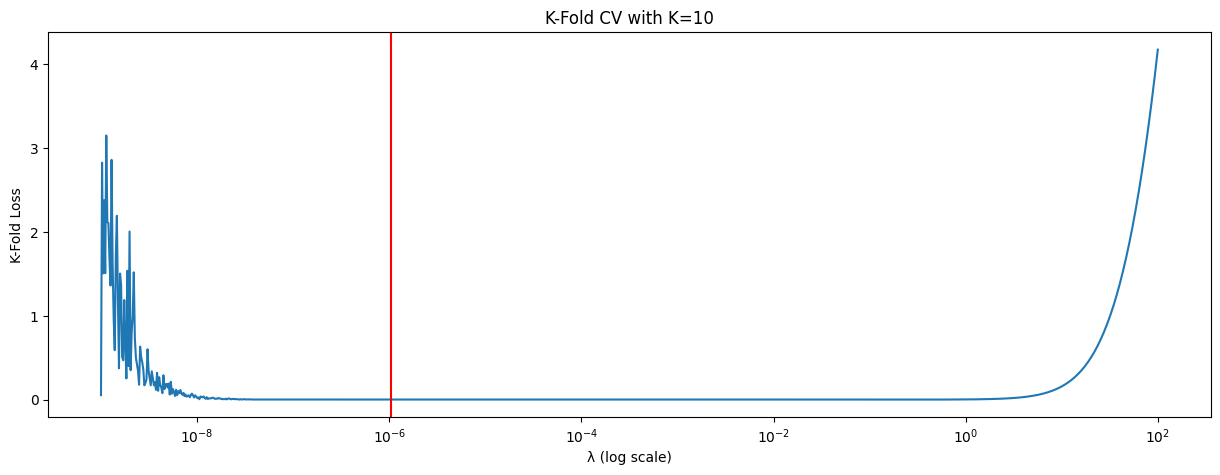

In [ ]:
#|column: screen-inset-left

candidate_lambdas = list(np.logspace(-9, 2, 1000))

def KFold(K, l):

  # Construct Folds
  folds = []
  n = X.shape[1]//K

  for i in range(K):
    folds.append((X[:, i*n:(i+1)*n], y[i*n:(i+1)*n]))

  l_mse = np.array([])
  # Cross validate over every validation partition

  for i in range(K):

    X_val, y_val = folds[i]

    X_train, y_train = np.array([[] for _ in range(d)]), np.array([])

    for j in range(K):
      if i != j:
        X_j, y_j = folds[j]
        X_train = np.column_stack((X_train, X_j))
        y_train = np.concatenate((y_train, y_j))

    l_mse = np.append(l_mse, validate(X_train, X_val, y_train, y_val, l))

  return(l_mse.mean())

lst = []
for l in candidate_lambdas:
  a = KFold(10, l)
  lst.append(a)
  # print(l, '|', round(a, 10))


fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(candidate_lambdas, lst)
ax.set_xscale("log")

best_lambda, best_loss = min(zip(candidate_lambdas, lst), key=lambda i: i[-1])
plt.axvline(x=best_lambda, color='red')

plt.xlabel("λ (log scale)")
plt.ylabel("K-Fold Loss")
plt.title("K-Fold CV with K=10")
plt.axis("tight");

print(f'Best Lambda: {best_lambda}')

## Leave-one-out Cross Validation
- Just K-Fold Validation, but with K set to the number of samples in our dataset.
- In other words, for n rounds, we choose just 1 element as the validation set, and the rest to be our train set.
- It is a computationally expensive procedure to perform, although it results in a reliable and unbiased estimate of model performance.

Best Lambda: 5.659170163246243e-07


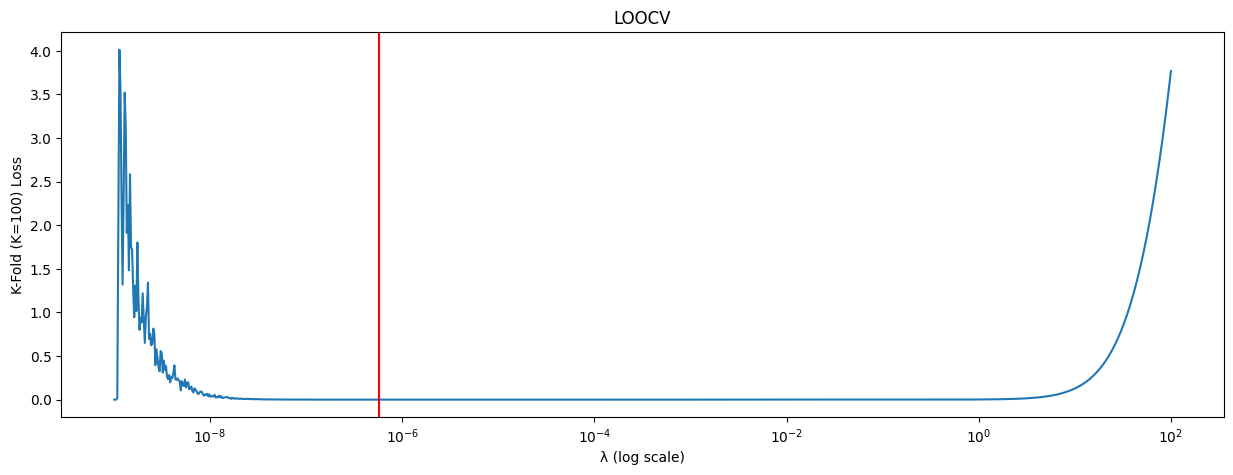

In [ ]:
#|column: screen-inset-left

candidate_lambdas = list(np.logspace(-9, 2, 1000))
lst = [KFold(100, l) for l in candidate_lambdas]

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(candidate_lambdas, lst)
ax.set_xscale("log")

best_lambda, best_loss = min(zip(candidate_lambdas, lst), key=lambda i: i[-1])
plt.axvline(x=best_lambda, color='red')

plt.xlabel("λ (log scale)")
plt.ylabel(f"K-Fold (K={n}) Loss")
plt.title("LOOCV")
plt.axis("tight");

print(f'Best Lambda: {best_lambda}')